In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [01:19<00:00, 52.4MB/s]
100% 4.00G/4.00G [01:19<00:00, 54.1MB/s]


In [5]:
! unzip /content/state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

# Import Libraries

In [1]:
#Files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob

#DATA
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

#CNN
from tensorflow.keras import layers
from keras import models 
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

#VIS
from keras.utils.vis_utils import plot_model

# Preprocessing Data

In [2]:
def preparData(path):
  imagsList = []
  labels = []
  for dic in sorted(glob.glob(os.path.join(path,'*')), key = lambda k: k.split('/')[-1]):
    for imgs in glob.glob(os.path.join(dic, '*.jpg')):
      img = cv2.imread(imgs)
      img_r = cv2.resize(img,(128,128))
      imagsList.append(img_r)
      labels.append(int(dic.split("/")[-1].replace('c','')))
  
  X_train, X_test, y_train, y_test = train_test_split(imagsList, labels, test_size=0.2)
  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return np.array(X_train), np.array(X_test), y_train, y_test


# Get Data

In [3]:
path_train = "/content/imgs/train/"
path_test  = "/content/imgs/test/"

X_train, X_test, y_train, y_test = preparData(path_train)

print(f"Size X_train: {len(X_train)}, Size y_train: {len(y_train)}")
print(f"Size X_test: {len(X_test)}, Size y_test {len(y_test)}")

Size X_train: 17939, Size y_train: 17939
Size X_test: 4485, Size y_test 4485


# Check Data Integrity

**Classes:**

- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger


(128, 128, 3)


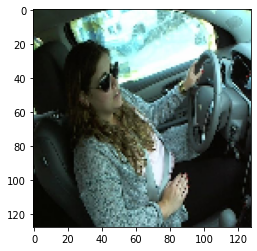

Class: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [4]:
print(X_train[202].shape)
img = X_train[202]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(f"Class: {y_train[202]}")

# Check Data Distribution

Text(0.5, 1.0, 'Classes')

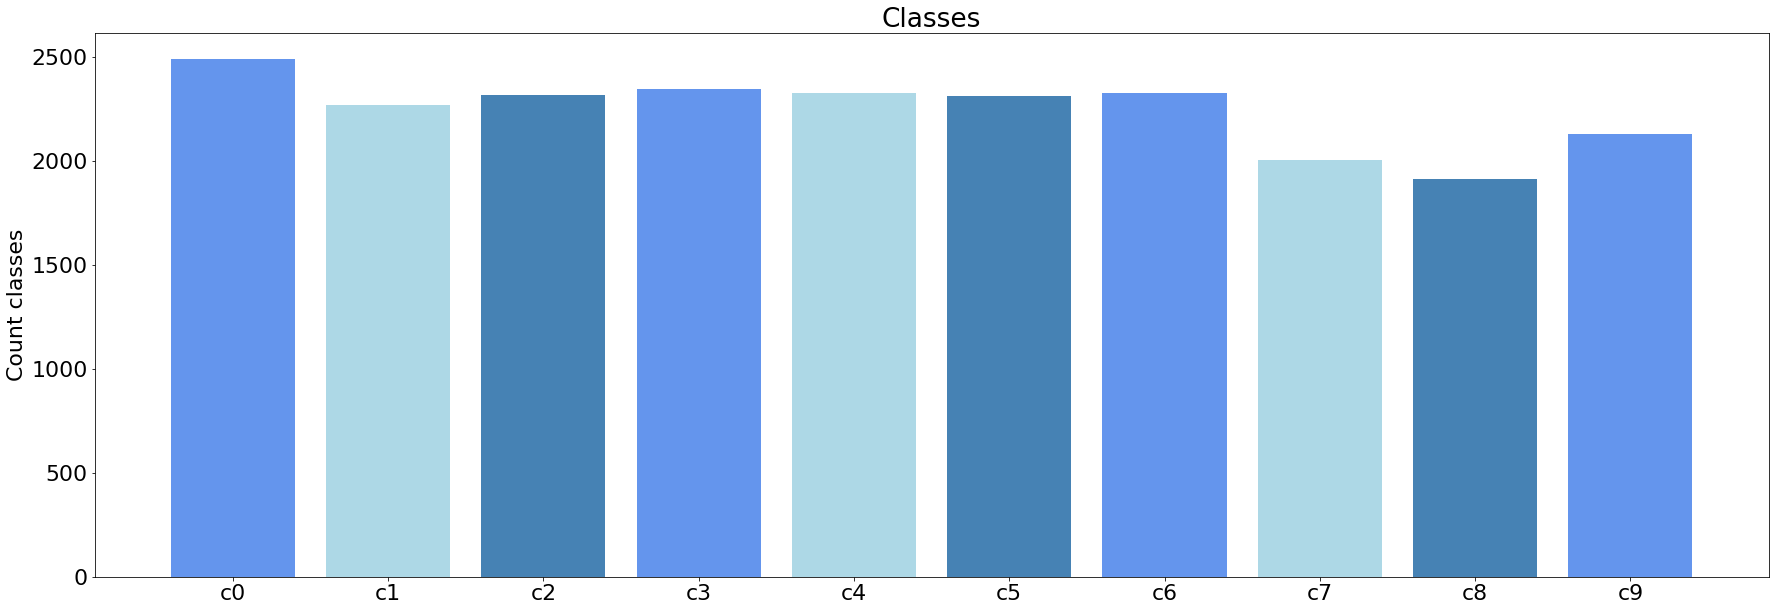

In [5]:
data_file = pd.read_csv("/content/driver_imgs_list.csv")
data_classes = data_file.loc[:,['classname','img']].groupby(by='classname').count().reset_index()

data_x = list(pd.unique(data_file['classname']))
data_y =list(data_classes['img'])


plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y, color=['cornflowerblue', 'lightblue', 'steelblue'])  
plt.ylabel('Count classes')
plt.title('Classes')

# Dense Model

In [6]:
model = models.Sequential()
model.add(layers.Reshape((16384*3,), input_shape=(128,128,3,)))
model.add(layers.Dense(512, activation='relu', name='Layer_1'))
model.add(layers.Dense(512, activation='relu', name='Layer_2'))
model.add(layers.Dense(256, activation='relu', name='Layer_3'))
model.add(layers.Dense(128, activation='relu', name='Layer_5'))
model.add(layers.Dense(10, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 49152)             0         
                                                                 
 Layer_1 (Dense)             (None, 512)               25166336  
                                                                 
 Layer_3 (Dense)             (None, 256)               131328    
                                                                 
 Layer_5 (Dense)             (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 25,331,850
Trainable params: 25,331,850
Non-trainable params: 0
_________________________________________________________________


Plot Model

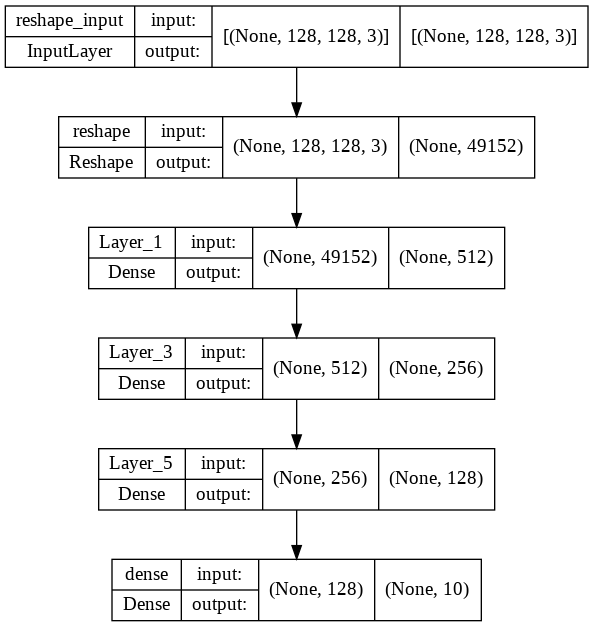

In [8]:
plot_model(model, show_shapes= True)

**Model Compile**

In [9]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

**Train Model**

In [10]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 512, validation_split = 0.2)

Epoch 1/10
29/29 [==============================] - 35s 1s/step - loss: 4329.6235 - accuracy: 0.1155 - val_loss: 1824.5038 - val_accuracy: 0.0967
Epoch 2/10
29/29 [==============================] - 34s 1s/step - loss: 802.1172 - accuracy: 0.1392 - val_loss: 327.1685 - val_accuracy: 0.2603
Epoch 3/10
29/29 [==============================] - 40s 1s/step - loss: 224.4475 - accuracy: 0.2288 - val_loss: 141.7302 - val_accuracy: 0.2742
Epoch 4/10
29/29 [==============================] - 34s 1s/step - loss: 88.5498 - accuracy: 0.3490 - val_loss: 72.8864 - val_accuracy: 0.4769
Epoch 5/10
29/29 [==============================] - 33s 1s/step - loss: 33.2877 - accuracy: 0.5200 - val_loss: 53.5937 - val_accuracy: 0.4601
Epoch 6/10
29/29 [==============================] - 34s 1s/step - loss: 36.8791 - accuracy: 0.5214 - val_loss: 77.3024 - val_accuracy: 0.3035
Epoch 7/10
29/29 [==============================] - 34s 1s/step - loss: 73.9177 - accuracy: 0.4258 - val_loss: 89.0015 - val_accuracy: 0.383

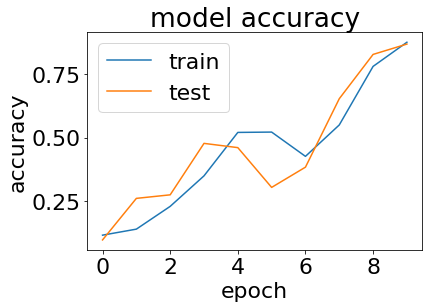

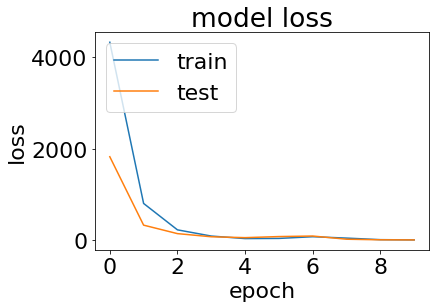

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Save Model

In [12]:
model.save('Dense_model.h5')